In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

# import multiprocessing

# np.random.seed(114514)
# xp.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


has cupy
has cupy
has BBHx waveform


## Likelihood

In [2]:

class Likelihood:
    # TODO: mode-by-mode heterodyne for the PhenonmHM waveform 
    def __init__(self, response_generator, frequency, data, invserse_covariance_matrix, response_parameters, use_gpu=False):
        """ 
        Args: 
            response_generator: generate frequency-domain TDI responses for given parameters 
            frequency: frequencies of data, numpy array of shape (Nf,), may not be evenly spaced at high frequencies due to the mask 
            data: frequency-domain tdi data, numpy array of shape (3, Nf)
            invserse_covariance_matrix: numpy array of shape (Nf, 3, 3), with Cov_IJ = CSD_IJ / 4 / Df, CSD_IJ = 2<I J^*>/T
            the SNR of signal h is defined as \sum_f h^\dagger C^-1 h 
            response_parameters: parameters of the response_generator besides source parameters and frequencies.
        """
        if frequency.shape[-1] != data.shape[-1] or frequency.shape[-1] != invserse_covariance_matrix.shape[0]:
            raise ValueError("shapes of data mismatch.")
        
        self.response_generator = response_generator
        self.frequency = frequency
        self.data = data 
        self.invserse_covariance_matrix = invserse_covariance_matrix 
        self.response_kwargs = response_parameters

        self.use_gpu = use_gpu
        if use_gpu: 
            self.xp = xp 
        else: 
            self.xp = np 

        self.frequency = self.xp.array(self.frequency)
        self.data = self.xp.array(data)
        self.invserse_covariance_matrix = self.xp.array(self.invserse_covariance_matrix)
        
        print("number of freuqncies:", len(frequency))
        print("min and max frequencies:", self.xp.min(frequency), self.xp.max(frequency))
        print("response kwargs:", self.response_kwargs)
        
        self.parameter_names = ['log_chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'log_luminosity_distance', 'cos_inclination', 'longitude', 'sin_latitude', 'psi']
        self.channel_names = ["X2", "Y2", "Z2"]
        self.het_prepare_flag = False 
        
    def full_log_like(self, parameter_array): 
        """ 
        Args: 
            parameter_array: parameters given as an array.
            the order is: ['log_chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'log_luminosity_distance', 'cos_inclination', 'longitude', 'sin_latitude', 'psi']
        Returns: 
            loglike 
        """
        template = self.response_generator.Response(
            parameters=ParamArr2ParamDict(parameter_array),
            freqs=self.frequency,
            **self.response_kwargs,
        ) # (3, Nf)
        residual = self.data - template # (3, Nf)
        
        if self.use_gpu:
            return (-0.5 * self.FrequencyDomainCovarianceSNR(data_channels=residual, inv_cov=self.invserse_covariance_matrix) ** 2).get() 
        else:
            return -0.5 * self.FrequencyDomainCovarianceSNR(data_channels=residual, inv_cov=self.invserse_covariance_matrix) ** 2 
        
    def full_log_like_vectorized(self, parameter_array): 
        """ 
        Args: 
            parameter_array: parameters given as an array of shape (Nparams, Nevents).
            the order is: ['log_chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'log_luminosity_distance', 'cos_inclination', 'longitude', 'sin_latitude', 'psi']
        Returns: 
            loglike of shape (Nevents)
        """
        template = self.response_generator.Response(
            parameters=ParamArr2ParamDict(parameter_array),
            freqs=self.frequency,
            **self.response_kwargs,
        ) # (3, Nevents, Nf)
        residual = self.xp.transpose(self.data - self.xp.transpose(template, (1, 0, 2)), (0, 2, 1)) # (Nevents, 3, Nf) -> (Nevents, Nf, 3)
        residual_dagger = self.xp.conjugate(residual[:, :, self.xp.newaxis, :]) # (Nevents, Nf, 1, 3)
        residual = residual[:, :, :, self.xp.newaxis] # (Nevents, Nf, 3, 1)
        loglikes = self.xp.sum(self.xp.matmul(self.xp.matmul(residual_dagger, self.invserse_covariance_matrix), residual), axis=(1,2,3))
        
        if self.use_gpu: 
            return np.real(-0.5 * loglikes.get()) 
        else: 
            return np.real(-0.5 * loglikes)
    
    def prepare_het_log_like(self, base_parameters=None, base_waveform=None, num_het_frequency=128):
        """ 
        Args: 
            base_parameters: None or numpy array of shape (Nparams)
            base_waveform: None or numpy array of shape (3, Nf)
            num_het_frequency: number of sparse frequencies to calculate the waveform perturbation, N_het_f = Nb + 1 
        """
        if base_waveform is None:
            self.h0 = self.response_generator.Response(
                parameters=ParamArr2ParamDict(base_parameters),
                freqs=self.frequency,
                **self.response_kwargs,
            ) # (3, Nf)
        else: 
            self.h0 = base_waveform.copy() 
            if self.h0.shape != self.data.shape:
                raise ValueError("shapes of waveforms mismatch.")
        
        # create sparce grid of frequencies (1st try)
        FMIN, FMAX = self.xp.min(self.frequency) * 0.999999999999, self.xp.max(self.frequency) * 1.000000000001
        self.het_frequency = self.xp.logspace(self.xp.log10(FMIN), self.xp.log10(FMAX), num_het_frequency) # N_het_f
        
        # calculate base waveform at the sparce grid (1st try)
        if base_waveform is None:
            self.het_h0 = self.response_generator.Response(
                parameters=ParamArr2ParamDict(base_parameters),
                freqs=self.het_frequency,
                **self.response_kwargs,
            ) # (3, N_het_f)
        else: 
            interp_amplitude = self.xp.abs(self.h0) # (3, Nf)
            interp_phase = self.xp.unwrap(self.xp.angle(self.h0)) # (3, Nf)
            self.het_h0 = self.xp.array([
                self.xp.interp(x=self.het_frequency, xp=self.frequency, fp=interp_amplitude[iii]) * self.xp.exp(1.j * self.xp.interp(x=self.het_frequency, xp=self.frequency, fp=interp_phase[iii])) for iii in range(3)
            ]) # (3, N_het_f)
        
        # refine the sparse grid to ensure no zero waveforms 
        # valid_idx = self.xp.where(self.xp.abs(self.het_h0[0]) != 0.)[0]
        valid_idx = self.xp.where(self.xp.abs(self.het_h0[0]) > 1e-23)[0]
        tmpf = self.het_frequency[valid_idx]
        
        # create sparce grid of frequencies (final)
        self.het_frequency = self.xp.logspace(self.xp.log10(tmpf[0]), self.xp.log10(tmpf[-1]), num_het_frequency) # N_het_f
        
        # calculate base waveform at the sparce grid (final)
        if base_waveform is None: 
            self.het_h0 = self.response_generator.Response(
                parameters=ParamArr2ParamDict(base_parameters),
                freqs=self.het_frequency,
                **self.response_kwargs,
            ) # (3, N_het_f)
        else: 
            self.het_h0 = self.xp.array([
                self.xp.interp(x=self.het_frequency, xp=self.frequency, fp=interp_amplitude[iii]) * self.xp.exp(1.j * self.xp.interp(x=self.het_frequency, xp=self.frequency, fp=interp_phase[iii])) for iii in range(3)
            ]) # (3, N_het_f)
        self.het_h0[self.het_h0==0.] = 1e-25 
        
        # confine the frequency and data to be within the boundaries of sparce grid 
        inband_idx = self.xp.where((self.frequency >= self.het_frequency[0]) & (self.frequency <= self.het_frequency[-1]))[0]
        self.dense_frequency = self.frequency[inband_idx] # (Nf)
        self.dense_data = self.data[:, inband_idx] # (3, Nf)
        self.dense_h0 = self.h0[:, inband_idx] # (3, Nf)
        self.dense_invserse_covariance_matrix = self.invserse_covariance_matrix[inband_idx] # (Nf, 3, 3)
        
        # group the dense frequencies with the sparce frequency grid, return the left idx of each dense frequency, each bin is labeled by this 
        group_idx = self.xp.searchsorted(self.het_frequency, self.dense_frequency, "right") - 1 # (Nf)
        dense_frequency_offset = self.dense_frequency - self.het_frequency[group_idx] # (Nf)
        
        # start pre-calculating the coefficients of heterodyned likelihood 
        # 1) h_h terms
        B0_pre = self.xp.matmul(self.xp.transpose(self.xp.conjugate(self.dense_h0))[:, :, self.xp.newaxis], self.xp.transpose(self.dense_h0)[:, self.xp.newaxis, :]) * self.dense_invserse_covariance_matrix # (Nf, 3, 1) * (Nf, 1, 3) -> (Nf, 3, 3)
        B1_pre = B0_pre * dense_frequency_offset[:, self.xp.newaxis, self.xp.newaxis] # (Nf, 3, 3)
        # 2) d_h terms 
        A0_pre = self.xp.matmul(self.xp.transpose(self.xp.conjugate(self.dense_data))[:, :, self.xp.newaxis], self.xp.transpose(self.dense_h0)[:, self.xp.newaxis, :]) * self.dense_invserse_covariance_matrix # (Nf, 3, 1) * (Nf, 1, 3) -> (Nf, 3, 3)
        A1_pre = A0_pre * dense_frequency_offset[:, self.xp.newaxis, self.xp.newaxis] # (Nf, 3, 3)
        
        # sum all the coefficients in sparce grids  
        self.Nbin = num_het_frequency - 1 
        self.B0 = self.xp.zeros((self.Nbin, 3, 3), dtype=self.xp.complex128)
        self.B1 = self.xp.zeros((self.Nbin, 3, 3), dtype=self.xp.complex128)
        self.A0 = self.xp.zeros((self.Nbin, 3, 3), dtype=self.xp.complex128)
        self.A1 = self.xp.zeros((self.Nbin, 3, 3), dtype=self.xp.complex128)
        for ibin in self.xp.unique(group_idx): # loop over the left idx of sparce grids 
            inbin_idx = group_idx == ibin 
            self.B0[ibin] = self.xp.sum(B0_pre[inbin_idx], axis=0) # (3, 3)
            self.B1[ibin] = self.xp.sum(B1_pre[inbin_idx], axis=0)
            self.A0[ibin] = self.xp.sum(A0_pre[inbin_idx], axis=0)
            self.A1[ibin] = self.xp.sum(A1_pre[inbin_idx], axis=0)
            
        self.het_df = self.het_frequency[1:] - self.het_frequency[:-1] # (Nb)
        self.het_prepare_flag = True 
        
    def het_log_like(self, parameter_array):
        """ 
        Args: 
            parameter_array: parameters given as an array.
            the order is: ['log_chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'log_luminosity_distance', 'cos_inclination', 'longitude', 'sin_latitude', 'psi']
        Returns: 
            heterodyned loglike 
        """
        if not self.het_prepare_flag: 
            raise NotImplementedError("heterodyne not prepared, run preparation first.")
            
        # calculate sparce template 
        het_h = self.response_generator.Response(
            parameters=ParamArr2ParamDict(parameter_array),
            freqs=self.het_frequency,
            **self.response_kwargs,
        ) # (3, N_het_f)
        
        # calculate heterodyne 
        het_r = self.xp.transpose(het_h / self.het_h0) # (N_het_f, 3)
        het_r = self.xp.nan_to_num(het_r, 0.) # deal with the nan caused by divide 0 
        het_r0 = het_r[:-1] # (Nb, 3)
        het_r1 = (het_r[1:] - het_r0) / self.het_df[:, self.xp.newaxis] # (Nb, 3)
        
        # calculate likelihood 
        # 1) h_h term 
        LL1 = self.xp.sum(self.xp.matmul(self.xp.conjugate(het_r0)[:, :, self.xp.newaxis], het_r0[:, self.xp.newaxis, :]) * self.B0) # sum((Nb, 3, 3) * (Nb, 3, 3)) -> scalar 
        tmp_mat = self.xp.matmul(self.xp.conjugate(het_r0)[:, :, self.xp.newaxis], het_r1[:, self.xp.newaxis, :]) # (Nb, 3, 3)
        LL1 += self.xp.sum((tmp_mat + self.xp.transpose((self.xp.conjugate(tmp_mat)), (0, 2, 1))) * self.B1) # sum((Nb, 3, 3) * (Nb, 3, 3)) -> scalar 
        # 2_ d_h term 
        LL2 = self.xp.sum(self.xp.matmul(self.A0, het_r0[:, :, self.xp.newaxis]))
        LL2 += self.xp.sum(self.xp.matmul(self.A1, het_r1[:, :, self.xp.newaxis]))

        # # test only 
        # self.LL1 = LL1 
        # self.LL2 = LL2 
        # self.het_h = het_h
        # self.het_r = het_r
        # self.het_r0 = het_r0
        # self.het_r1 = het_r1
        
        # test only 
        # LL1 = 0.  
        self.output = [LL1, self.xp.real(LL2)]
        
        res = self.xp.nan_to_num(self.xp.real(-0.5 * LL1 + LL2), nan=-self.xp.infty)
        if self.use_gpu: 
            return res.get()
        else:
            return res
        
        
    def het_log_like_vectorized(self, parameter_array):
        """ 
        Args: 
            parameter_array: parameters given as an array of shape (Nparams, Nevents)
            the order is: ['log_chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'log_luminosity_distance', 'cos_inclination', 'longitude', 'sin_latitude', 'psi']
        Returns: 
            numpy array of heterodyned loglikes 
        """
        if not self.het_prepare_flag: 
            raise NotImplementedError("heterodyne not prepared, run preparation first.")
            
        # calculate sparce template 
        het_h = self.xp.transpose(self.response_generator.Response(
            parameters=ParamArr2ParamDict(parameter_array),
            freqs=self.het_frequency,
            **self.response_kwargs,
        ), (1, 0, 2)) # (Nevents, 3, N_het_f)
        # print("shape of het_h", het_h.shape)
        
        # calculate heterodyne 
        het_r = self.xp.transpose(het_h / self.het_h0, (0, 2, 1)) # (Nevents, N_het_f, 3)
        het_r = self.xp.nan_to_num(het_r, 0.) # deal with the nan caused by divide 0 
        het_r0 = het_r[:, :-1, :] # (Nevents, Nb, 3)
        het_r1 = (het_r[:, 1:, :] - het_r0) / self.het_df[:, self.xp.newaxis] # (Nevents, Nb, 3)
        # print("shape of r, r0, r1", het_r.shape, het_r0.shape, het_r1.shape)
        
        # calculate likelihood 
        # 1) h_h term 
        LL1 = self.xp.sum(self.xp.matmul(self.xp.conjugate(het_r0)[:, :, :, self.xp.newaxis], het_r0[:, :, self.xp.newaxis, :]) * self.B0, axis=(1, 2, 3)) # sum((Nevents, Nb, 3, 3) * (Nb, 3, 3)) -> (Nevents)
        tmp_mat = self.xp.matmul(self.xp.conjugate(het_r0)[:, :, :, self.xp.newaxis], het_r1[:, :, self.xp.newaxis, :]) # (Nevents, Nb, 3, 3)
        LL1 += self.xp.sum((tmp_mat + self.xp.transpose((self.xp.conjugate(tmp_mat)), (0, 1, 3, 2))) * self.B1, axis=(1, 2, 3)) # sum((Nevents, Nb, 3, 3) * (Nb, 3, 3)) -> (Nevents)
        # 2_ d_h term 
        LL2 = self.xp.sum(self.xp.matmul(self.A0[self.xp.newaxis, :, :, :], het_r0[:, :, :, self.xp.newaxis]), axis=(1, 2, 3)) # (Nevents)
        LL2 += self.xp.sum(self.xp.matmul(self.A1[self.xp.newaxis, :, :, :], het_r1[:, :, :, self.xp.newaxis]), axis=(1, 2, 3)) # (Nevents)
        # print("shape of tmpmat", tmp_mat.shape)

        # test 
        # LL1 = 0. # test 
        self.output_vec = [LL1, self.xp.real(LL2)]
        
        res = self.xp.nan_to_num(self.xp.real(-0.5 * LL1 + LL2), nan=-self.xp.infty)
        if self.use_gpu: 
            return res.get()
        else:
            return res
        
    def marginal_log_like(self, parameter_array):
        """ 
        Args: 
            parameter_array: parameters given as an array.
            the order is: ['log_chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'cos_inclination', 'longitude', 'sin_latitude', 'psi']
        Returns: 
            loglike marginalized over luminosity distance 
        """
        p = dict()
        p['chirp_mass'] = np.power(10., parameter_array[0])
        p['mass_ratio'] = parameter_array[1]
        p['spin_1z'] = parameter_array[2]
        p['spin_2z'] = parameter_array[3]
        p['coalescence_time'] = parameter_array[4]
        p['coalescence_phase'] = parameter_array[5]
        p['luminosity_distance'] = 1. 
        p['inclination'] = np.arccos(parameter_array[6])
        p['longitude'] = parameter_array[7]
        p['latitude'] = np.arcsin(parameter_array[8])
        p['psi'] = parameter_array[9] 

        template = self.response_generator.Response(
            parameters=p,
            freqs=self.frequency,
            **self.response_kwargs,
        ) # (3, Nf)
        B_term = self.xp.real(self.FrequencyDomainCovarianceInnerProduct(data_channels1=template, data_channels2=self.data, inv_cov=self.invserse_covariance_matrix))
        if B_term < 0.:
            result = 0. 
        else:
            C_term = self.FrequencyDomainCovarianceSNR(data_channels=template, inv_cov=self.invserse_covariance_matrix) ** 2
            result = B_term ** 2 / C_term / 2.

        if self.use_gpu:
            return result.get() 
        else:
            return result
        
    def calculate_marginalized_parameter(self, parameter_array):
        """ 
        Args: 
            parameter_array: parameters given as an array.
            the order is: ['log_chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'cos_inclination', 'longitude', 'sin_latitude', 'psi']
        Returns: 
            calculate luminosity distance in [MPC] given the maximum estimation of other parameters  
        """
        p = dict()
        p['chirp_mass'] = np.power(10., parameter_array[0])
        p['mass_ratio'] = parameter_array[1]
        p['spin_1z'] = parameter_array[2]
        p['spin_2z'] = parameter_array[3]
        p['coalescence_time'] = parameter_array[4]
        p['coalescence_phase'] = parameter_array[5]
        p['luminosity_distance'] = 1. 
        p['inclination'] = np.arccos(parameter_array[6])
        p['longitude'] = parameter_array[7]
        p['latitude'] = np.arcsin(parameter_array[8])
        p['psi'] = parameter_array[9] 

        template = self.response_generator.Response(
            parameters=p,
            freqs=self.frequency,
            **self.response_kwargs,
        ) # (3, Nf)
        B_term = self.xp.real(self.FrequencyDomainCovarianceInnerProduct(data_channels1=template, data_channels2=self.data, inv_cov=self.invserse_covariance_matrix))
        C_term = self.FrequencyDomainCovarianceSNR(data_channels=template, inv_cov=self.invserse_covariance_matrix) ** 2 

        if self.use_gpu:
            return np.abs((C_term / B_term).get())
        else:
            return np.abs(C_term / B_term)
        
    def FrequencyDomainCovarianceSNR(self, data_channels, inv_cov):
        """  
        Args:
            data_channels: numpy array of shape (3, Nf)
            inv_cov: numpy array of shape (Nf, 3, 3), with Cov_IJ = CSD_IJ / 4 / Df, CSD_IJ = 2<I J^*>/T
        Returns: 
            sqrt(d^\dagger C^-1 d), real scalar 
        """
        data_expanded = self.xp.transpose(data_channels)[:,self.xp.newaxis,:] # (Nf, 1, 3)
        data_expanded_transposed = self.xp.transpose(data_expanded, (0, 2, 1)) # (Nf, 3, 1)
        tmp1 = self.xp.matmul(self.xp.conjugate(data_expanded), inv_cov) # (Nf, 1, 3)
        tmp2 = self.xp.matmul(tmp1, data_expanded_transposed) # (Nf, 1, 1)
        return self.xp.sqrt(self.xp.real(self.xp.sum(tmp2)))
    
    def FrequencyDomainCovarianceInnerProduct(self, data_channels1, data_channels2, inv_cov):
        """  
        Args:
            data_channels1, 2: numpy arraies of shapes (3, Nf)
            inv_cov: numpy array of shape (Nf, 3, 3), with Cov_IJ = CSD_IJ / 4 / Df, CSD_IJ = 2<I J^*>/T
        Returns: 
            d_1^\dagger C^-1 d_2, complex scalar 
        """
        data_expanded1 = self.xp.transpose(data_channels1)[:,self.xp.newaxis,:] # (Nf, 1, 3)
        data_expanded2 = self.xp.transpose(data_channels2)[:,self.xp.newaxis,:] # (Nf, 1, 3)
        data_expanded_transposed2 = self.xp.transpose(data_expanded2, (0, 2, 1)) # (Nf, 3, 1)
        tmp1 = self.xp.matmul(self.xp.conjugate(data_expanded1), inv_cov) # (Nf, 1, 3)
        tmp2 = self.xp.matmul(tmp1, data_expanded_transposed2) # (Nf, 1, 1)
        return self.xp.sum(tmp2)

## F-stat 

In [3]:



import copy 

class Fstatistics(Likelihood):
    extrinsic_parameter_names = [
        "luminosity_distance", 
        "inclination", 
        "coalescence_phase", 
        "psi"
        ]
    intrinsic_parameter_names = [
        'chirp_mass',
        'mass_ratio',
        'spin_1z',
        'spin_2z',
        'coalescence_time',
        'longitude',
        'latitude'
        ]
    def __init__(self, response_generator, frequency, data, invserse_covariance_matrix, response_parameters, use_gpu=False):
        super().__init__(response_generator, frequency, data, invserse_covariance_matrix, response_parameters, use_gpu)
        self.SUM = self.xp.sum 
        self.CONJ = self.xp.conjugate
        self.RE = self.xp.real
        self.NX = self.xp.newaxis 
        self.MATMUL = self.xp.matmul
        self.TRANS = self.xp.transpose

    def self_inner_product_vectorized(self, template_channels):
        """ 
            template_channels: shape (Nevent, Nchannel, Nfreq)
        """
        residual = self.TRANS(template_channels, (0, 2, 1)) # (Nevent, 3, Nf) -> (Nevent, Nf, 3)
        residual_dagger = self.CONJ(residual[:, :, self.NX, :]) # (Nevent, Nf, 1, 3)
        residual = residual[:, :, :, self.NX] # (Nevent, Nf, 3, 1)
        inners = self.SUM(self.MATMUL(self.MATMUL(residual_dagger, self.invserse_covariance_matrix), residual), axis=(1,2,3)) # (Nevent)
        return self.RE(inners) # (Nevent)
    
    def inner_product_vectorized(self, template_channels1, template_channels2):
        """ 
            template_channels1: shape (Nevent, Nchannel, Nfreq)
            template_channels2: shape (Nevent, Nchannel, Nfreq)
        """
        residual1 = self.TRANS(template_channels1, (0, 2, 1)) # (Nevent, 3, Nf) -> (Nevent, Nf, 3)
        residual_dagger1 = self.CONJ(residual1[:, :, self.NX, :]) # (Nevent, Nf, 1, 3)

        residual2 = self.TRANS(template_channels2, (0, 2, 1)) # (Nevent, 3, Nf) -> (Nevent, Nf, 3)
        residual2 = residual2[:, :, :, self.NX] # (Nevent, Nf, 3, 1)

        inners = self.SUM(self.MATMUL(self.MATMUL(residual_dagger1, self.invserse_covariance_matrix), residual2), axis=(1,2,3)) # (Nevent)
        return self.RE(inners) # (Nevent)
    
    def self_inner_product_vectorized_margin_time(self, template_channels, full_frequencies=None, valid_indices=None):
        """ 
            template_channels: shape (Nevent, Nchannel, Nfreq)
        """
        residual = self.TRANS(template_channels, (0, 2, 1)) # (Nevent, 3, Nf) -> (Nevent, Nf, 3)
        residual_dagger = self.CONJ(residual[:, :, self.NX, :]) # (Nevent, Nf, 1, 3)
        residual = residual[:, :, :, self.NX] # (Nevent, Nf, 3, 1)
        inners_f = self.RE(self.SUM(self.MATMUL(self.MATMUL(residual_dagger, self.invserse_covariance_matrix), residual), axis=(2,3))) # (Nevent, Nf)
        if full_frequencies is not None: 
            inners_f_filled = self.xp.zeros((inners_f.shape[0], full_frequencies.shape), dtype=self.xp.float64) # (Nevent, Nf_filled)
            inners_f_filled[:, valid_indices] = inners_f
        else: 
            inners_f_filled = inners_f # (Nevent, Nf_filled=Nf)
        inners_t = self.xp.fft.irfft(inners_f_filled, axis=-1) # (Nevent, Nf_filled)
        inners = self.xp.max(inners_t, axis=-1) # (Nevent)
        return inners 
    
    def inner_product_vectorized_margin_time(self, template_channels1, template_channels2, full_frequencies=None, valid_indices=None):
        """ 
            template_channels1: shape (Nevent, Nchannel, Nfreq)
            template_channels2: shape (Nevent, Nchannel, Nfreq)
        """
        residual1 = self.TRANS(template_channels1, (0, 2, 1)) # (Nevent, 3, Nf) -> (Nevent, Nf, 3)
        residual_dagger1 = self.CONJ(residual1[:, :, self.NX, :]) # (Nevent, Nf, 1, 3)

        residual2 = self.TRANS(template_channels2, (0, 2, 1)) # (Nevent, 3, Nf) -> (Nevent, Nf, 3)
        residual2 = residual2[:, :, :, self.NX] # (Nevent, Nf, 3, 1)

        inners_f = self.RE(self.SUM(self.MATMUL(self.MATMUL(residual_dagger1, self.invserse_covariance_matrix), residual2), axis=(2,3))) # (Nevent, Nf)
        if full_frequencies is not None: 
            inners_f_filled = self.xp.zeros((inners_f.shape[0], full_frequencies.shape), dtype=self.xp.float64) # (Nevent, Nf_filled)
            inners_f_filled[:, valid_indices] = inners_f
        else: 
            inners_f_filled = inners_f # (Nevent, Nf_filled=Nf)
        inners_t = self.xp.fft.irfft(inners_f_filled, axis=-1) # (Nevent, Nf_filled)
        inners = self.xp.max(inners_t, axis=-1) # (Nevent)
        return inners # (Nevent)

    def calculate_Fstat_vectorized(self, intrinsic_parameters, return_a=False, return_recovered_wave=False):
        """  
        calculate F-statistics for a batch of events TODO: expand to HM waveform 
        Args: 
            intrinsic_parameters: dictionary of intrinsic parameters (except for D, iota, phic, psi), each item is a numpy array of shape (Nevent). 
        Returns: 
            F-statistics of events 
        """
        Nevent = len(np.atleast_1d(intrinsic_parameters["chirp_mass"]))
        
        full_parameters1 = copy.deepcopy(intrinsic_parameters)
        full_parameters1["luminosity_distance"] = np.ones(Nevent) * 0.25 
        full_parameters1["coalescence_phase"] = np.zeros(Nevent)
        full_parameters1["inclination"] = np.ones(Nevent) * PI / 2. 
        full_parameters1["psi"] = np.zeros(Nevent)
        # print("1st parameter set:") # TEST 
        # print(full_parameters1) # TEST 

        temp1 = self.response_generator.Response(
            parameters=full_parameters1,
            freqs=self.frequency,
            **self.response_kwargs,
        ) # (Nchannel=3, Nevent, Nfreq)
        
        full_parameters2 = copy.deepcopy(full_parameters1)
        full_parameters2["psi"] = np.ones(Nevent) * PI / 4. 
        # print("2nd parameter set:") # TEST 
        # print(full_parameters2) # TEST 

        temp2 = self.response_generator.Response(
            parameters=full_parameters2,
            freqs=self.frequency,
            **self.response_kwargs,
        ) # (Nchannel=3, Nevent, Nfreq)

        if Nevent == 1:
            temp1 = temp1[:, self.NX, :]
            temp2 = temp2[:, self.NX, :]

        X1 = self.TRANS(temp1, axes=(1, 0, 2)) # (Nevent, Nchannel, Nfreq)
        X2 = 1.j * X1 # (Nevent, Nchannel, Nfreq)
        X3 = self.TRANS(temp2, axes=(1, 0, 2)) # (Nevent, Nchannel, Nfreq)
        X4 = 1.j * X3 # (Nevent, Nchannel, Nfreq) 
        # print("shape of X1:", X1.shape) # TEST 
        
        data_expand = self.data[self.NX, :, :] # (1, Nchannel, Nfreq)
        Nvector = self.TRANS(self.xp.array([
            self.inner_product_vectorized(data_expand, X1), 
            self.inner_product_vectorized(data_expand, X2), 
            self.inner_product_vectorized(data_expand, X3), 
            self.inner_product_vectorized(data_expand, X4), 
        ])) # (4, Nevent) -> (Nevent, 4) inner products, all real numbers 
        # print("shape of N vector:", Nvector.shape) # TEST 
        
        M12 = self.inner_product_vectorized(X1, X2) # (Nevent), real numbers 
        M13 = self.inner_product_vectorized(X1, X3)
        M14 = self.inner_product_vectorized(X1, X4)
        M23 = self.inner_product_vectorized(X2, X3)
        M24 = self.inner_product_vectorized(X2, X4)
        M34 = self.inner_product_vectorized(X3, X4)
        Mmatrix = self.TRANS(self.xp.array([
            [self.self_inner_product_vectorized(X1), M12, M13, M14], 
            [M12, self.self_inner_product_vectorized(X2), M23, M24], 
            [M13, M23, self.self_inner_product_vectorized(X3), M34], 
            [M14, M24, M34, self.self_inner_product_vectorized(X4)]
        ]), axes=(2, 0, 1)) # (4, 4, Nevent) -> (Nevent, 4, 4) inner products, all real numbers 
        # print("shape of M matrix:", Mmatrix.shape) # TEST 
        
        invMmatrix = self.xp.linalg.inv(Mmatrix) # (Nevent, 4, 4)
        
        Nvector_col = Nvector[..., self.NX] # (Nevent, 4, 1)
        NM = self.MATMUL(invMmatrix, Nvector_col) # (Nevent, 4, 1)
        Nvector_row = Nvector[:, self.NX, :] # (Nevent, 1, 4)
        NMN = self.MATMUL(Nvector_row, NM) # (Nevent, 1, 1)
        
        res = 0.5 * NMN[:, 0, 0] # (Nevent) Fstat 0.5 * N^T M^{-1} N
        
        if return_a:
            res_a = NM.squeeze(axis=-1) # (Nevent, 4)
            if self.use_gpu:
                return res_a.get() # (Nevent, 4)
            else: 
                return res_a # (Nevent, 4)
            
        if return_recovered_wave: 
            res_a = NM.squeeze(axis=-1) # (Nevent, 4)
            res_wf = res_a[:, 0] * self.TRANS(X1, axes=(1, 2, 0)) # (Nchannel, Nfreq, Nevent)
            res_wf += res_a[:, 1] * self.TRANS(X2, axes=(1, 2, 0))
            res_wf += res_a[:, 2] * self.TRANS(X3, axes=(1, 2, 0))
            res_wf += res_a[:, 3] * self.TRANS(X4, axes=(1, 2, 0)) 
            return self.TRANS(res_wf, (0, 2, 1)) # (Nchannel, Nevent, Nfreq)

        # else:
        if self.use_gpu:
            return res.get() # (Nevent)
        else: 
            return res 
        
    def calculate_Fstat_vectorized_margin_time(self, intrinsic_parameters, return_a=False, return_recovered_wave=False, fiducial_tc=0.):
        """  
        calculate F-statistics for a batch of events TODO: expand to HM waveform 
        Args: 
            intrinsic_parameters: dictionary of intrinsic parameters (except for D, iota, phic, psi, tc), each item is a numpy array of shape (Nevent). 
        Returns: 
            F-statistics of events 
        """
        Nevent = len(np.atleast_1d(intrinsic_parameters["chirp_mass"]))
        
        full_parameters1 = copy.deepcopy(intrinsic_parameters)
        full_parameters1["luminosity_distance"] = np.ones(Nevent) * 0.25 
        full_parameters1["coalescence_phase"] = np.zeros(Nevent)
        full_parameters1["inclination"] = np.ones(Nevent) * PI / 2. 
        full_parameters1["psi"] = np.zeros(Nevent)
        full_parameters1["coalescence_time"] = fiducial_tc
        # print("1st parameter set:") # TEST 
        # print(full_parameters1) # TEST 

        temp1 = self.response_generator.Response(
            parameters=full_parameters1,
            freqs=self.frequency,
            **self.response_kwargs,
        ) # (Nchannel=3, Nevent, Nfreq)
        
        full_parameters2 = copy.deepcopy(full_parameters1)
        full_parameters2["psi"] = np.ones(Nevent) * PI / 4. 
        # print("2nd parameter set:") # TEST 
        # print(full_parameters2) # TEST 

        temp2 = self.response_generator.Response(
            parameters=full_parameters2,
            freqs=self.frequency,
            **self.response_kwargs,
        ) # (Nchannel=3, Nevent, Nfreq)

        if Nevent == 1:
            temp1 = temp1[:, self.NX, :]
            temp2 = temp2[:, self.NX, :]

        X1 = self.TRANS(temp1, axes=(1, 0, 2)) # (Nevent, Nchannel, Nfreq)
        X2 = 1.j * X1 # (Nevent, Nchannel, Nfreq)
        X3 = self.TRANS(temp2, axes=(1, 0, 2)) # (Nevent, Nchannel, Nfreq)
        X4 = 1.j * X3 # (Nevent, Nchannel, Nfreq) 
        # print("shape of X1:", X1.shape) # TEST 
        
        data_expand = self.data[self.NX, :, :] # (1, Nchannel, Nfreq)
        Nvector = self.TRANS(self.xp.array([
            self.inner_product_vectorized_margin_time(data_expand, X1), 
            self.inner_product_vectorized_margin_time(data_expand, X2), 
            self.inner_product_vectorized_margin_time(data_expand, X3), 
            self.inner_product_vectorized_margin_time(data_expand, X4), 
        ])) # (4, Nevent) -> (Nevent, 4) inner products, all real numbers 
        # print("shape of N vector:", Nvector.shape) # TEST 
        
        M12 = self.inner_product_vectorized_margin_time(X1, X2) # (Nevent), real numbers 
        M13 = self.inner_product_vectorized_margin_time(X1, X3)
        M14 = self.inner_product_vectorized_margin_time(X1, X4)
        M23 = self.inner_product_vectorized_margin_time(X2, X3)
        M24 = self.inner_product_vectorized_margin_time(X2, X4)
        M34 = self.inner_product_vectorized_margin_time(X3, X4)
        Mmatrix = self.TRANS(self.xp.array([
            [self.self_inner_product_vectorized_margin_time(X1), M12, M13, M14], 
            [M12, self.self_inner_product_vectorized_margin_time(X2), M23, M24], 
            [M13, M23, self.self_inner_product_vectorized_margin_time(X3), M34], 
            [M14, M24, M34, self.self_inner_product_vectorized_margin_time(X4)]
        ]), axes=(2, 0, 1)) # (4, 4, Nevent) -> (Nevent, 4, 4) inner products, all real numbers 
        # print("shape of M matrix:", Mmatrix.shape) # TEST 
        
        invMmatrix = self.xp.linalg.inv(Mmatrix) # (Nevent, 4, 4)
        
        Nvector_col = Nvector[..., self.NX] # (Nevent, 4, 1)
        NM = self.MATMUL(invMmatrix, Nvector_col) # (Nevent, 4, 1)
        Nvector_row = Nvector[:, self.NX, :] # (Nevent, 1, 4)
        NMN = self.MATMUL(Nvector_row, NM) # (Nevent, 1, 1)
        
        res = 0.5 * NMN[:, 0, 0] # (Nevent) Fstat 0.5 * N^T M^{-1} N
        
        if return_a:
            res_a = NM.squeeze(axis=-1) # (Nevent, 4)
            if self.use_gpu:
                return res_a.get() # (Nevent, 4)
            else: 
                return res_a # (Nevent, 4)
            
        if return_recovered_wave: 
            res_a = NM.squeeze(axis=-1) # (Nevent, 4)
            res_wf = res_a[:, 0] * self.TRANS(X1, axes=(1, 2, 0)) # (Nchannel, Nfreq, Nevent)
            res_wf += res_a[:, 1] * self.TRANS(X2, axes=(1, 2, 0))
            res_wf += res_a[:, 2] * self.TRANS(X3, axes=(1, 2, 0))
            res_wf += res_a[:, 3] * self.TRANS(X4, axes=(1, 2, 0)) 
            return self.TRANS(res_wf, (0, 2, 1)) # (Nchannel, Nevent, Nfreq)

        # else:
        if self.use_gpu:
            return res.get() # (Nevent)
        else: 
            return res 
        
    @staticmethod
    def a_to_extrinsic_vectorized(a):
        """ 
        TODO: expand to HM waveform 
        Args: 
            a: (Nevent, 4), numpy array of the a coefficients 
        Returns: 
            dictionary of extrinsic parameters 
        """
        extrinsic_parameters = dict()
        
        P = np.linalg.norm(a, axis=1) ** 2 # (Nevent)
        Q = a[:, 1] * a[:, 2] - a[:, 0] * a[:, 3] # (Nevent)
        Delta = np.sqrt(P ** 2 - 4. * Q ** 2) # (Nevent)
        Aplus = np.sqrt((P + Delta) / 2.) # (Nevent)
        Across = np.sign(Q) * np.sqrt((P - Delta) / 2.) # (Nevent)
        
        tmp = Aplus + np.sqrt(Aplus ** 2 - Across ** 2) # (Nevent)
        extrinsic_parameters["luminosity_distance"] = 0.5 / tmp # (Nevent)
        extrinsic_parameters["inclination"] = np.arccos(Across / tmp) # (Nevent)
        # extrinsic_parameters["coalescence_phase"] = -np.arctan(2. * (a[:, 0] * a[:, 1] + a[:, 2] * a[:, 3]) / (a[:, 0] ** 2 + a[:, 2] ** 2 - a[:, 1] ** 2 - a[:, 3] ** 2)) / 2. # (Nevent), one possible solution 
        # extrinsic_parameters["psi"] = np.arctan(2. * (a[:, 0] * a[:, 2] + a[:, 1] * a[:, 3]) / (a[:, 0] ** 2 + a[:, 1] ** 2 - a[:, 2] ** 2 - a[:, 3] ** 2)) / 4. # (Nevent), one possible solution 

        P = np.sqrt((a[:, 0] + a[:, 3])**2 + (a[:, 1] - a[:, 2])**2)
        Q = np.sqrt((a[:, 0] - a[:, 3])**2 + (a[:, 1] + a[:, 2])**2)
        Aplus = P + Q 
        Across = P - Q 
        A = Aplus + np.sqrt(Aplus**2 + Across**2)
        extrinsic_parameters["psi"] = 0.5 * np.arctan((Aplus*a[:, 3] - Across*a[:, 0]) / (Aplus*a[:, 1] + Across*a[:, 2]))
        extrinsic_parameters["coalescence_phase"] = -0.5*np.arctan((Aplus*a[:, 3] - Across*a[:, 0]) / (Aplus*a[:, 2] + Across*a[:, 1])) 
        extrinsic_parameters["psi"][extrinsic_parameters["psi"]<0.] += PI 
        extrinsic_parameters["coalescence_phase"][extrinsic_parameters["coalescence_phase"]<0.] += 2.*PI 
        # extrinsic_parameters["inclination"] = np.arccos(-Across/A)
        
        if a.shape[0] == 1:
            extrinsic_parameters_out = dict() 
            for k, v in extrinsic_parameters.items():
                extrinsic_parameters_out[k] = v[0]
            return extrinsic_parameters_out
        else:              
            return extrinsic_parameters
    
    @staticmethod
    def IntParamDict2ParamArr(param_dict):
        return np.array([
            np.log10(param_dict['chirp_mass']),
            param_dict['mass_ratio'],
            param_dict['spin_1z'],
            param_dict['spin_2z'],
            param_dict['coalescence_time'],
            param_dict['longitude'],
            np.sin(param_dict['latitude']),
        ]) # (Nparams, Nevent)

    @staticmethod
    def IntParamArr2ParamDict(params):
        p = dict()
        p['chirp_mass'] = np.power(10., params[0])
        p['mass_ratio'] = params[1]
        p['spin_1z'] = params[2]
        p['spin_2z'] = params[3]
        p['coalescence_time'] = params[4]
        p['longitude'] = params[5]
        p['latitude'] = np.arcsin(params[6])
        return p 

## Data settings 

In [4]:
t_start = 10. * DAY # start time in s
Tobs = 5. * DAY # data length in s 
t_end = t_start + Tobs # end time in s 
dt = 10. # time cadance in s 
fsample = 1. / dt # sampling rate in Hz 
data_frequencies_full = np.fft.rfftfreq(n=int(Tobs/dt), d=dt) # frequecies where waveform will be calculated 
delta_f = 1. / Tobs

data_frequencies_full.shape 

(21601,)

In [5]:
# mask the "null" frequencies, which may cause singularity in the calculation of likelihood 
mask = np.ones_like(data_frequencies_full, dtype=bool)
for i in range(1, 50): 
    mask_idx = np.where(np.abs(data_frequencies_full - i*0.025)<i*3e-4)[0]
    mask[mask_idx] = False 

# remove the frequencies below Taiji sensitive band 
mask_idx = np.where(data_frequencies_full < 1e-5)[0]
mask[mask_idx] = False 

data_frequencies = data_frequencies_full[mask]
data_frequencies_GPU = xp.array(data_frequencies)

valid_idx = np.where(mask == True)[0]

data_frequencies.shape, valid_idx.shape 

((21077,), (21077,))

## Set response model 

In [6]:
# the path of Taiji orbit 
orbit_GPU = Orbit(OrbitDir="../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB") # create individial orbit objects for CPU and GPU to avoid the confusion of numpy / cupy orbit data 

# initialize  waveform generator 
WFG_GPU = BBHxWaveformGenerator(mode="primary", use_gpu=True)

# initialize response generator 
FDTDI_GPU = BBHxFDTDIResponseGenerator(orbit_class=orbit_GPU, waveform_generator=WFG_GPU, use_gpu=True)

# response settings 
response_kwargs_GPU = dict(
    modes=[(2,2)], 
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
    interpolation=True,
)

## Source parameter priors 

In [7]:
lgMc_prior = [5.5, 6.5]
q_prior = [0.1, 1]
s1_prior = [-0.9, 0.9]
s2_prior = [-0.9, 0.9]
tc_prior = [t_start/DAY+3., t_end/DAY] # ensure at least 3-day data before merger 
lam_prior = [0, TWOPI]
sinbeta_prior = [-1., 1.]
intrinsic_param_priors = np.array([
    lgMc_prior, 
    q_prior, 
    s1_prior, 
    s2_prior, 
    tc_prior, 
    lam_prior, 
    sinbeta_prior, 
])

lgdl_prior = [4., 5.]

intrinsic_param_priors

array([[ 5.5       ,  6.5       ],
       [ 0.1       ,  1.        ],
       [-0.9       ,  0.9       ],
       [-0.9       ,  0.9       ],
       [13.        , 15.        ],
       [ 0.        ,  6.28318531],
       [-1.        ,  1.        ]])

## Noise model 

In [8]:
arm_time = (t_start + t_end) / 2. 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit_GPU.LTTfunctions()[key](arm_time)

# theoretical PSDs at the given armlengths 
PSDfunc = TDIPSDs()
PSD_channels = np.array([
    PSDfunc.PSD_A2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_E2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_T2_unequal(data_frequencies, arms)
])

# covariance matrix 
CovMat = np.array([
    [PSD_channels[0], np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), PSD_channels[1], np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = np.linalg.inv(np.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)
InvCovMat[:, 2, 2] *= 0. # use A, E channels only in the following analysis 

PSD_channels.shape, InvCovMat.shape 

((3, 21077), (21077, 3, 3))

## Data simulation 

In [9]:
# generate source parameter and clean signal 
mbhb_parameters = {
    'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
    'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
    'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
    'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
    'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
    'coalescence_phase': np.random.uniform(0, TWOPI),
    'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
    'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
    'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
    'psi': np.random.uniform(0, PI) # [rad]
    }
wf_channels = FDTDI_GPU.Response(mbhb_parameters, data_frequencies_GPU, **response_kwargs_GPU)

# generate frequency-domain noises 
Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

# combine signal and noise 
data_channels = wf_channels + noise_channels 

opt_SNR = FrequencyDomainCovarianceSNR(wf_channels.get(), InvCovMat)

print("source parameters:")
for k, v in mbhb_parameters.items():
    print(k, ":", v)
print("optimal SNR:", opt_SNR)

source parameters:
chirp_mass : 2036862.1509524677
mass_ratio : 0.27396201294212963
spin_1z : -0.5884501817920502
spin_2z : -0.3066600635072003
coalescence_time : 14.821230041709233
coalescence_phase : 4.341089463532374
luminosity_distance : 49106.41668303898
inclination : 2.452423536157308
longitude : 4.439931571315981
latitude : 0.45096182701120896
psi : 2.6761981286754923
optimal SNR: 1335.7090753508687


Text(0, 0.5, 'Frequency-domain data (1/Hz)')

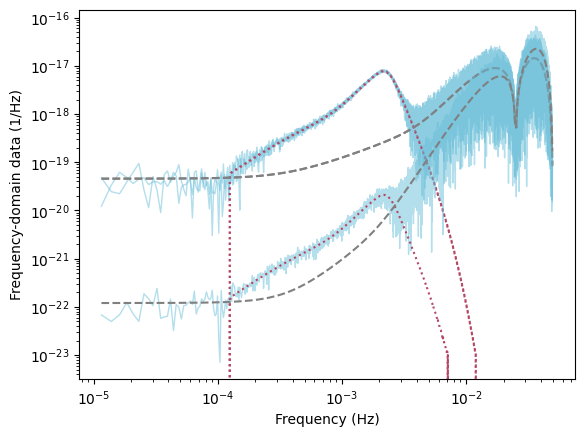

In [10]:
for ichannel, nchannel in enumerate(["A", "E", "T"]): 
    plt.loglog(data_frequencies, np.abs(data_channels[ichannel].get()), linewidth=1, alpha=0.5, color=BLUE)
    plt.loglog(data_frequencies, np.abs(wf_channels[ichannel].get()), color=RED, linestyle=":")
    plt.loglog(data_frequencies, np.sqrt(PSD_channels[ichannel] * Tobs / 2.), color="grey", linestyle="--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency-domain data (1/Hz)")

## MLE with  $\mathcal{F}$-stat 

In [11]:
Fstat = Fstatistics(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_GPU, 
    use_gpu=True
)

number of freuqncies: 21077
min and max frequencies: 1.1574074074074073e-05 0.04939814814814815
response kwargs: {'modes': [(2, 2)], 'tmin': 10.0, 'tmax': 15.0, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': True}


### test waveform and parameter recovery

In [12]:
int_params = dict()
for key in Fstatistics.intrinsic_parameter_names:
    int_params[key] = mbhb_parameters[key]
int_params

{'chirp_mass': 2036862.1509524677,
 'mass_ratio': 0.27396201294212963,
 'spin_1z': -0.5884501817920502,
 'spin_2z': -0.3066600635072003,
 'coalescence_time': 14.821230041709233,
 'longitude': 4.439931571315981,
 'latitude': 0.45096182701120896}

In [13]:
rec_a = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=int_params, 
    return_a=True, 
)

rec_ext_params = Fstat.a_to_extrinsic_vectorized(rec_a)

rec_params = dict(int_params, **rec_ext_params)

print("parameter name | difference")
for k, v in rec_ext_params.items():
    print(k, ":", v-mbhb_parameters[k])

parameter name | difference
luminosity_distance : 179.93554139246407
inclination : 0.005142659781054881
psi : 0.01879934154337004
coalescence_phase : 1.5515490726269547


In [14]:
# rec_wave = FDTDI_GPU.Response(
#     rec_params, 
#     data_frequencies_GPU, 
#     **response_kwargs_GPU
# )

# it turns out that this method is better than the other 
rec_wave = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=int_params, 
    return_recovered_wave=True, 
)[:, 0, :]
rec_wave.shape 

(3, 21077)

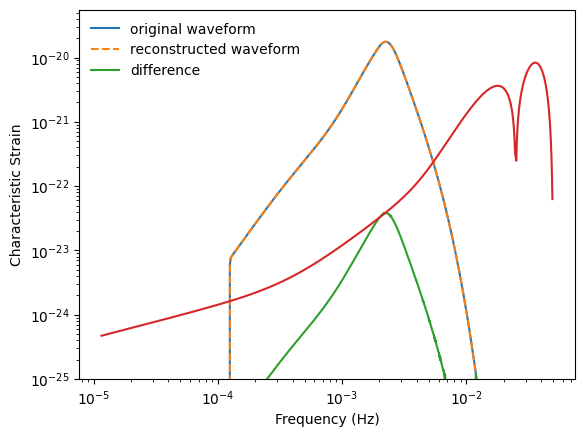

In [15]:
plt.loglog(data_frequencies, np.abs(wf_channels[0].get()) * data_frequencies, label="original waveform")
plt.loglog(data_frequencies, np.abs(rec_wave[0].get()) * data_frequencies, linestyle="--", label="reconstructed waveform")
plt.loglog(data_frequencies, np.abs(rec_wave[0].get() - wf_channels[0].get()) * data_frequencies, label="difference")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies))
plt.ylim(1e-25,)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")
plt.legend(loc="upper left", frameon=False)

### optimization from prior 

In [16]:
from scipy.optimize import differential_evolution

# n_dim_int = len(Fstatistics.intrinsic_parameter_names)
# print("number of parameters to be optimized:", n_dim_int)

def cost_function(norm_int_params):
    """   
        norm_int_params: shape (Nparams, Nevent), normalized to (0, 1)
    """
    int_params = norm_int_params.transpose() * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nevent, Nparams)
    params_in = Fstat.IntParamArr2ParamDict(int_params.transpose()) # (Nparams, Nevent) -> dictionary, each item (Nevent)
    return -Fstat.calculate_Fstat_vectorized(intrinsic_parameters=params_in) # (Nevent)

n_dim_int = 7 
lower_bounds = np.zeros(n_dim_int) 
upper_bounds = np.ones(n_dim_int) 
bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

DE_results = [] 
DE_fun = [] 
DE_res_snr = [] 
for _ in range(1):
    tmp = differential_evolution(
        func=cost_function,
        bounds=bounds,
        x0=None,
        strategy='best1exp',
        # strategy='rand1bin',
        maxiter=5000,
        popsize=10*n_dim_int,
        # popsize=6*n_dim_int, 
        tol=1e-7,
        atol=1e-9,
        # tol=1e-6,
        # atol=1e-8,
        mutation=(0.4, 0.95),
        recombination=0.7,
        disp=False,
        polish=False,
        vectorized=True,
    )
    DE_results.append(tmp)
    DE_fun.append(tmp.fun)

    searched_int_params = Fstat.IntParamArr2ParamDict(tmp.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])
    searched_a = Fstat.calculate_Fstat_vectorized(
        intrinsic_parameters=searched_int_params, 
        return_a=True, 
    ) # (1, 4)
    searched_ext_params = Fstat.a_to_extrinsic_vectorized(searched_a)
    searched_params = dict(searched_int_params, **searched_ext_params)
    # searched_wf = FDTDI_GPU.Response(
    #     searched_params, 
    #     data_frequencies_GPU, 
    #     **response_kwargs_GPU
    # )
    searched_wf = Fstat.calculate_Fstat_vectorized(
        searched_int_params, 
        return_recovered_wave=True 
    )[:, 0, :]
    searched_residual = (searched_wf - data_channels).get()
    DE_res_snr.append(np.sqrt(np.abs(FrequencyDomainCovarianceSNR(data_channels=searched_residual, inv_cov=InvCovMat))))

DE_result = DE_results[np.argmin(np.array(DE_res_snr))]
print(DE_result)

/home/ps/miniconda3/envs/tdc/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


             message: Optimization terminated successfully.
             success: True
                 fun: -892080.0313107558
                   x: [ 8.091e-01  1.937e-01  1.689e-01  3.506e-01
                        9.147e-01  3.652e-01  1.558e-01]
                 nit: 376
                nfev: 377
          population: [[ 8.091e-01  1.937e-01 ...  3.652e-01  1.558e-01]
                       [ 8.091e-01  1.938e-01 ...  3.671e-01  1.621e-01]
                       ...
                       [ 8.091e-01  1.938e-01 ...  3.660e-01  1.580e-01]
                       [ 8.090e-01  1.936e-01 ...  3.710e-01  1.651e-01]]
 population_energies: [-8.921e+05 -8.921e+05 ... -8.921e+05 -8.921e+05]


In [17]:
DE_res_snr

[17.02626384498157]

### reconstruct parameters and waveforms 

In [18]:
searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])

searched_a = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=searched_int_params, 
    return_a=True, 
) # (1, 4)
searched_ext_params = Fstat.a_to_extrinsic_vectorized(searched_a)

searched_params = dict(searched_int_params, **searched_ext_params)

print("parameter name | difference")
for k, v in searched_params.items():
    print(k, np.abs(v-mbhb_parameters[k]))

parameter name | difference
chirp_mass 472.596113567939
mass_ratio 0.00039523027186005866
spin_1z 0.007583663072458169
spin_2z 0.037664149349137865
coalescence_time 0.008244389908847793
longitude 2.145421676962465
latitude 1.2101171546170046
luminosity_distance 6533.077807515008
inclination 1.7148295512084273
psi 0.21603906569263298
coalescence_phase 1.4188392673048407


(1e-25, 5.545956015589682e-20)

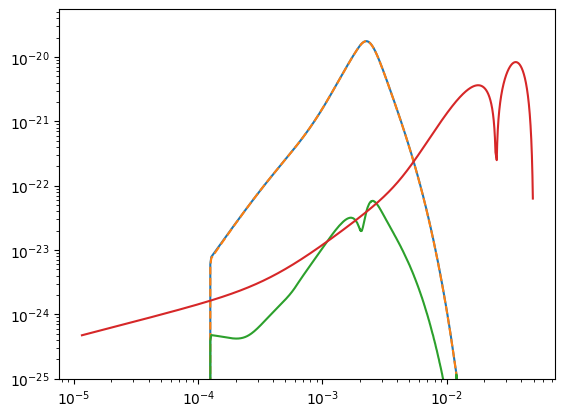

In [19]:
searched_wf = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=searched_int_params, 
    return_recovered_wave=True
)[:, 0, :]

# searched_wf = FDTDI_GPU.Response(
#     searched_params, 
#     data_frequencies_GPU, 
#     **response_kwargs_GPU
# )

plt.loglog(data_frequencies, np.abs(wf_channels[0].get()) * data_frequencies)
plt.loglog(data_frequencies, np.abs(searched_wf[0].get()) * data_frequencies, linestyle="--")
plt.loglog(data_frequencies, np.abs(searched_wf[0].get() - wf_channels[0].get()) * data_frequencies, linestyle="-")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies))
plt.ylim(1e-25, )

## Fisher analysis 

In [20]:
def fisher_waveform_wrapper(param_dict, frequencies):
    res = FDTDI_GPU.Response(
        parameters=param_dict, 
        freqs=xp.array(frequencies),  
        **response_kwargs_GPU, 
    )
    return res.get()

# set initial steps 
analyze_param_step_dict = {
    'chirp_mass': 10.,
    'mass_ratio': 0.01,
    'spin_1z': 0.01,
    'spin_2z': 0.01,
    'coalescence_time': 0.001,
    'coalescence_phase': 0.01,
    'luminosity_distance': 10.,
    'inclination': 0.01,
    'longitude': 0.01,
    'latitude': 0.01,
    'psi': 0.01
    }
for k, v in analyze_param_step_dict.items():
    analyze_param_step_dict[k] = -v 

FIM = MultiChannelFisher(
    waveform_generator=fisher_waveform_wrapper, 
    # param_dict=mbhb_parameters, 
    param_dict=searched_params, 
    analyze_param_step_dict=analyze_param_step_dict, 
    frequency=data_frequencies, 
    inverse_covariance=InvCovMat, 
    verbose=0,
)

FIM.auto_test_step()
FIM.calculate_Fisher()
FIM.calculate_errors() 

FIM.param_errors

{'chirp_mass': 1390.0989243362126,
 'mass_ratio': 0.0016599587299242935,
 'spin_1z': 0.02183728532665153,
 'spin_2z': 0.0874380029468599,
 'coalescence_time': 0.00035392913105535294,
 'coalescence_phase': 0.09567364523824094,
 'luminosity_distance': 2573.8070057427262,
 'inclination': 0.05301821954251396,
 'longitude': 0.14776304811045177,
 'latitude': 0.11700629457158111,
 'psi': 0.171203401290112}

In [21]:
print("parameter name | difference | FIM bound | ratio")
for k, v in searched_params.items():
    print(k, np.abs(v-mbhb_parameters[k]), FIM.param_errors[k], np.abs(v-mbhb_parameters[k]) / FIM.param_errors[k])

parameter name | difference | FIM bound | ratio
chirp_mass 472.596113567939 1390.0989243362126 0.3399730086070017
mass_ratio 0.00039523027186005866 0.0016599587299242935 0.23809644464961133
spin_1z 0.007583663072458169 0.02183728532665153 0.34728048651737004
spin_2z 0.037664149349137865 0.0874380029468599 0.4307526256292485
coalescence_time 0.008244389908847793 0.00035392913105535294 23.293900347407142
longitude 2.145421676962465 0.14776304811045177 14.51933825403208
latitude 1.2101171546170046 0.11700629457158111 10.342325248806931
luminosity_distance 6533.077807515008 2573.8070057427262 2.5382935833721345
inclination 1.7148295512084273 0.05301821954251396 32.34415576391336
psi 0.21603906569263298 0.171203401290112 1.261885360131046
coalescence_phase 1.4188392673048407 0.09567364523824094 14.829990681046278


In [22]:
# test_dtc = np.linspace(-1e-2, 1e-2, 1000) 
# test_dsnr = np.zeros_like(test_dtc)

# for i in range(len(test_dtc)):
#     test_dsnr[i] = FrequencyDomainCovarianceSNR(data_channels=(wf_channels-searched_wf*xp.exp(1.j*TWOPI*data_frequencies_GPU*test_dtc[i]*DAY)).get(), inv_cov=InvCovMat)

In [23]:
# plt.plot(test_dtc, test_dsnr)
# plt.vlines(mbhb_parameters["coalescence_time"] - searched_params["coalescence_time"], 0, 10000)

## Test across population 

In [ ]:
truths_list = [] 
searched_list = [] 
FIM_bound_list = [] 
snr_list = [] 

for i in tqdm(range(100)):

    # generate source parameter and clean signal 
    mbhb_parameters = {
        'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
        'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
        'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
        'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
        'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
        'coalescence_phase': np.random.uniform(0, TWOPI),
        'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
        'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
        'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
        'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
        'psi': np.random.uniform(0, PI) # [rad]
        }
    wf_channels = FDTDI_GPU.Response(mbhb_parameters, data_frequencies_GPU, **response_kwargs_GPU)

    # generate frequency-domain noises 
    Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
    Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
    noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

    # combine signal and noise 
    data_channels = wf_channels + noise_channels 

    opt_SNR = FrequencyDomainCovarianceSNR(wf_channels.get(), InvCovMat)
    snr_list.append(opt_SNR)

    # print("source parameters:")
    # for k, v in mbhb_parameters.items():
    #     print(k, ":", v)
    # print("optimal SNR:", opt_SNR)

    Fstat = Fstatistics(
        response_generator=FDTDI_GPU, 
        frequency=data_frequencies_GPU, 
        data=data_channels, 
        invserse_covariance_matrix=InvCovMat, 
        response_parameters=response_kwargs_GPU, 
        use_gpu=True
    )

    # from scipy.optimize import differential_evolution

    # n_dim_int = len(Fstatistics.intrinsic_parameter_names)
    # print("number of parameters to be optimized:", n_dim_int)

    def cost_function(norm_int_params):
        """   
            norm_int_params: shape (Nparams, Nevent), normalized to (0, 1)
        """
        int_params = norm_int_params.transpose() * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nevent, Nparams)
        params_in = Fstat.IntParamArr2ParamDict(int_params.transpose()) # (Nparams, Nevent) -> dictionary, each item (Nevent)
        return -Fstat.calculate_Fstat_vectorized(intrinsic_parameters=params_in) # (Nevent)

    n_dim_int = 7 
    lower_bounds = np.zeros(n_dim_int) 
    upper_bounds = np.ones(n_dim_int) 
    bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

    DE_result = differential_evolution(
        func=cost_function,
        bounds=bounds,
        x0=None,
        strategy='best1exp',
        # strategy='rand1bin',
        maxiter=5000,
        popsize=10*n_dim_int,
        # popsize=6*n_dim_int, 
        tol=1e-7,
        atol=1e-9,
        # tol=1e-6,
        # atol=1e-8,
        mutation=(0.4, 0.95),
        recombination=0.7,
        disp=False,
        polish=False,
        vectorized=True,
    )

    searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])

    searched_a = Fstat.calculate_Fstat_vectorized(
        intrinsic_parameters=searched_int_params, 
        return_a=True, 
    ) # (1, 4)
    searched_ext_params = Fstat.a_to_extrinsic_vectorized(searched_a)

    searched_params = dict(searched_int_params, **searched_ext_params)

    def fisher_waveform_wrapper(param_dict, frequencies):
        res = FDTDI_GPU.Response(
            parameters=param_dict, 
            freqs=xp.array(frequencies),  
            **response_kwargs_GPU, 
        )
        return res.get()

    # set initial steps 
    analyze_param_step_dict = {
        'chirp_mass': 10.,
        'mass_ratio': 0.01,
        'spin_1z': 0.01,
        'spin_2z': 0.01,
        'coalescence_time': 0.001,
        'coalescence_phase': 0.01,
        'luminosity_distance': 10.,
        'inclination': 0.01,
        'longitude': 0.01,
        'latitude': 0.01,
        'psi': 0.01
        }
    for k, v in analyze_param_step_dict.items():
        analyze_param_step_dict[k] = -v 

    FIM = MultiChannelFisher(
        waveform_generator=fisher_waveform_wrapper, 
        param_dict=mbhb_parameters, 
        # param_dict=searched_params, 
        analyze_param_step_dict=analyze_param_step_dict, 
        frequency=data_frequencies, 
        inverse_covariance=InvCovMat, 
        verbose=0,
    )

    FIM.auto_test_step()
    FIM.calculate_Fisher()
    FIM.calculate_errors() 

    truths_list.append(mbhb_parameters)
    searched_list.append(searched_params)
    FIM_bound_list.append(FIM.param_errors)